<class 'pandas.core.frame.DataFrame'>
Index: 230736 entries, 230736 to 461471
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      230736 non-null  datetime64[ns]
 1   y       230736 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23741 entries, 0 to 23740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23741 non-null  datetime64[ns]
 1   y       23741 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 371.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      228 non-null    datetime64[ns]
 1   y       228 non-null    float64       
dtypes: datetime64[ns](1),

C:\Users\rafae\AppData\Local\Temp\ipykernel_17552\395939822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


<class 'pandas.core.frame.DataFrame'>
Index: 136374 entries, 0 to 136373
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      136374 non-null  datetime64[ns]
 1   y       136374 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 MB


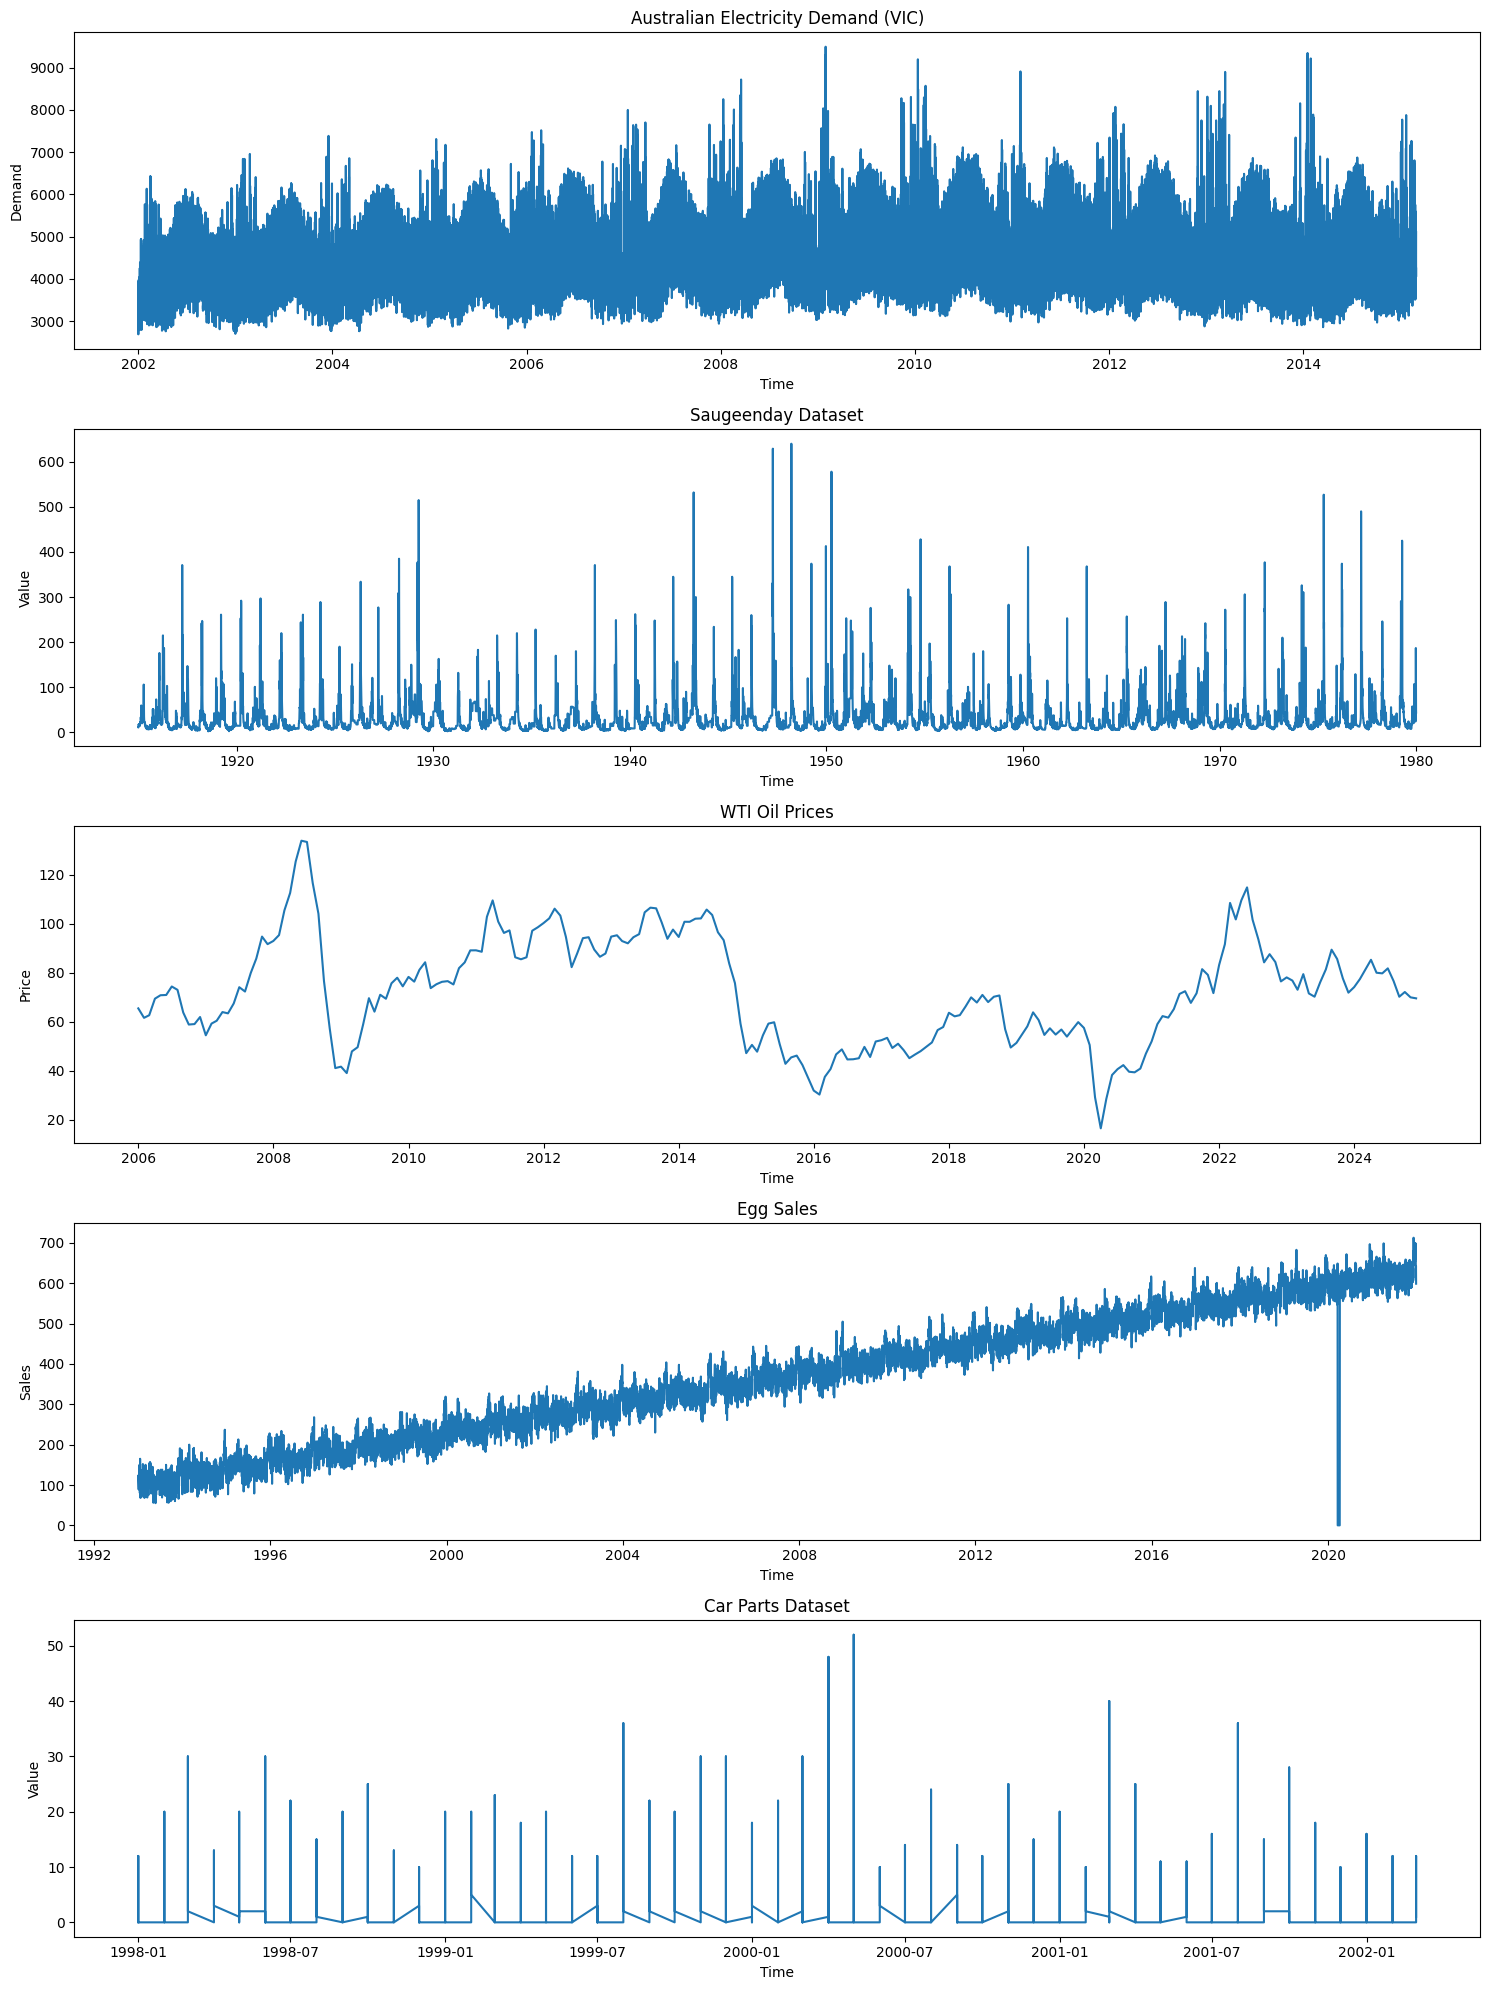

In [2]:
%run "datagetter.ipynb"

In [12]:
df = australian_electricity_demand_df.copy()
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds')

# Daily aggregate (if not already daily)
df = (
    df.set_index('ds')['y']
      .resample('D')
      .sum()
      .dropna()
      .reset_index()
)

df['unique_id'] = 'australian_demand'
df = df[['unique_id', 'ds', 'y']]



In [43]:
horizon = 128  # Forecast one year (365 days) ahead 
train_df = df.iloc[:-horizon]
test_df  = df.iloc[-horizon:]


In [42]:
import timesfm

# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [34]:
series = train_df['y'].values  # numpy array, shape [context_length,]


In [35]:
input_series = [series]  # Shape: (1, N)


In [40]:
mean_forecast, full_forecast = tfm.forecast(
    input_series,            # [your_series]
    window_size=365,        # or try a value like 365 for yearly trend
    forecast_context_len=365, # (optional)
    normalize=True           # or False, try both if in doubt
)


In [44]:
print("future_dates:", len(future_dates))
print("forecast_values:", len(forecast_values))


future_dates: 365
forecast_values: 128


In [45]:
# 1. Prepare the context (e.g. last N days up to now)
series = train_df['y'].astype(float).values  # ensure float!
input_series = [series]  # shape (1, N)

# 2. Run forecast
H = horizon  # e.g., 365

mean_forecast, full_forecast = tfm.forecast(
    input_series,
    window_size=None,           # or set to 365, etc.
    forecast_context_len=None,  # try None or set a value
    normalize=True              # True often works well for stable scale
)

# 3. Extract output
forecast_values = mean_forecast[0]   # shape: (H,)

# 4. Create a date index for plotting
last_date = train_df['ds'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=H, freq='D')

forecast_df = pd.DataFrame({
    'ds': future_dates,
    'yhat': forecast_values
})


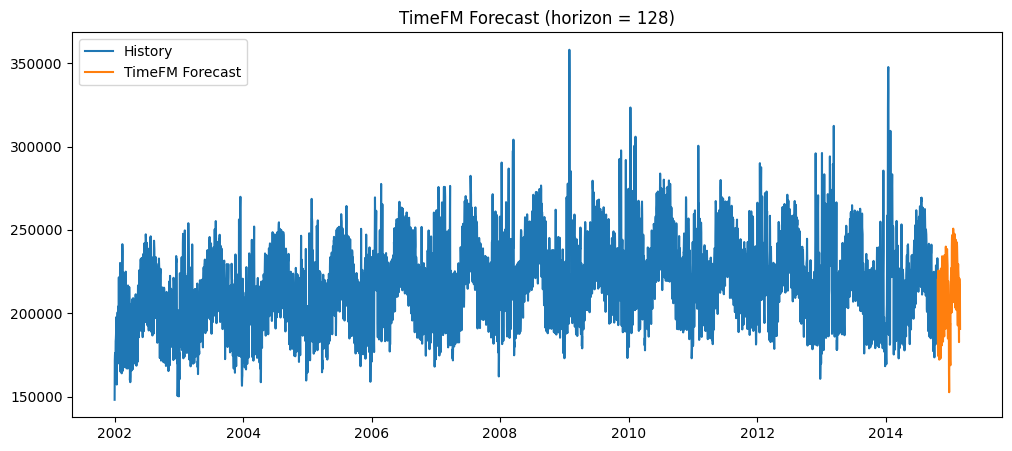

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='History')
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='TimeFM Forecast')
plt.legend()
plt.title("TimeFM Forecast (horizon = {})".format(H))
plt.show()
